In [1]:
import numpy as np
import pandas as pd
import obspy

import matplotlib.pyplot as plt
import seaborn as sns

import pylab as pl
import time


from DataGenerator import DataGenerator
from Models import Models
from LoadData import LoadData
from BaselineHelperFunctions import BaselineHelperFunctions
from RandomGridSearch import RandomGridSearch
from CustomCallback import CustomCallback
from MinMaxScalerFitter import MinMaxScalerFitter
from StandardScalerFitter import StandardScalerFitter
from sklearn.preprocessing import StandardScaler
from DataHandler import DataHandler

from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams["figure.figsize"]= (15,15)
helper = BaselineHelperFunctions()

import sys
ISCOLAB = 'google.colab' in sys.modules

import random
import json
import pprint
from obspy import Stream, Trace, UTCDateTime
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})


In [2]:
csv_root = 'csv_folder_3_class'
loadData = LoadData(csv_root, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
handler = DataHandler(csv_root)
pp = pprint.PrettyPrinter(indent=4)

In [3]:
scalerFitter = StandardScalerFitter(train_ds)
scaler = scalerFitter.fit_scaler(test = False, detrend = False)


***Questions:***
 - Need better data (shorter and more succinct, and events centered)?
 - Viable to normalize EQ and EX events based on magnitude and distance?
 - Filters filters filters
 - GAN development for larger dataset or augmentation? Randomizing noise difficult due to unlabeled time of EQ (?)
 - Are my samples really 1.5hrs long? Potential problems.. Short samples may lack P or S wave, while long
   samples may contain too much noise.
 - Should I spend time learning about Fourier transformations?
 - Simple explenation of Nyquist theorem?
 - Consider reducing scope to two classes due to significant limitations of data?


***Observations and facts:***

 - In the study: EQs in range M3.4 - M9.1. Most of my EQs are <M3. Makes classification more difficult.

 - P wave 60% faster than S wave

 - P wave more prominent in vertical seisometers: Z graph.
 - Poorly labeled dataset so hard to tell which one it is in my data. Assuming same format as the previous dataset the 0th channel should be the Z axis.
 - Very limited data samples limit depth of networks
 - Low magnitude EQs make discrimination very difficult.


***Further work related to data:***
 - Graphing of magnitude distribution in the dataset of both EX and EQ.
 - Graphing of distance distribution in the dataset of both EX and EQ. Expect EX samples to largely happen in the same places.
 - Determine some optimal filter to apply to the dataset.
 - Augment dataset
 - Oversample to normalize
 - Confusion matrix: does the model predict the same class every time or totally random.




In [104]:
single_dp_index = 30
# 18, 19, 24, 25, 30 - eq
"""
30th eq: Does the EQ start right away? Most data just noise?
"""
# 26, 27, 29, 31 - ex
# 20, 21, 22, 23 - noise

one_X, one_y = train_ds[single_dp_index]

one_X, one_info = handler.path_to_trace(one_X)
one_X_sc= scalerFitter.transform_sample(one_X)

#print(one_X)
print(one_y)
pp.pprint(one_info)
#print(one_X_sc)

earthquake
{   'az_to_arces': 80.64121642012557,
    'baz_to_arces': 295.6467633226664,
    'dist_to_arces': 1375.0857526581165,
    'event_type': 'earthquake',
    'event_type_certainty': 'known',
    'magnitude_dist_ratio': 0.0020398727821721524,
    'magnitude_sqrtdist_ratio': 0.07564286584994574,
    'magnitudes': [   {   'mag': 2.805,
                          'magnitude_type': 'Mb',
                          'origin_id': 'smi:local/0abdd8c3-402b-4228-908b-af4c954744bc',
                          'resource_id': 'smi:local/fecaad8a-92ff-4d33-92ec-9cc6d7679d41'},
                      {   'mag': -9.99,
                          'magnitude_type': 'Ml',
                          'origin_id': 'smi:local/0abdd8c3-402b-4228-908b-af4c954744bc',
                          'resource_id': 'smi:local/819e1a8a-ca9f-45b9-8d76-3a6a44c07c10'}],
    'origins': [   {   'comments': [   {   'resource_id': 'smi:local/f84abe12-402a-4842-a05d-054986adde85',
                                           'tex

In [105]:
start_time = one_info['origins'][0]['time']

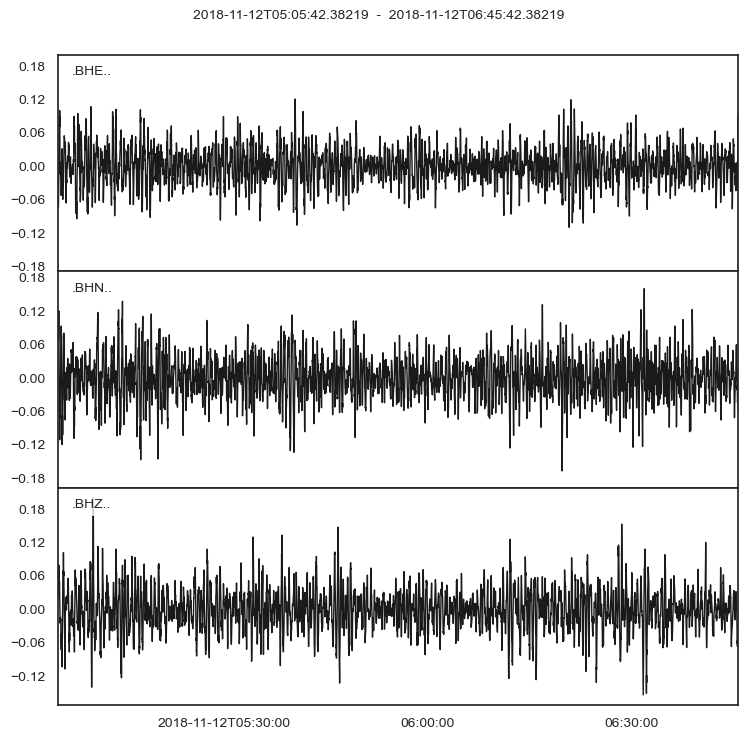

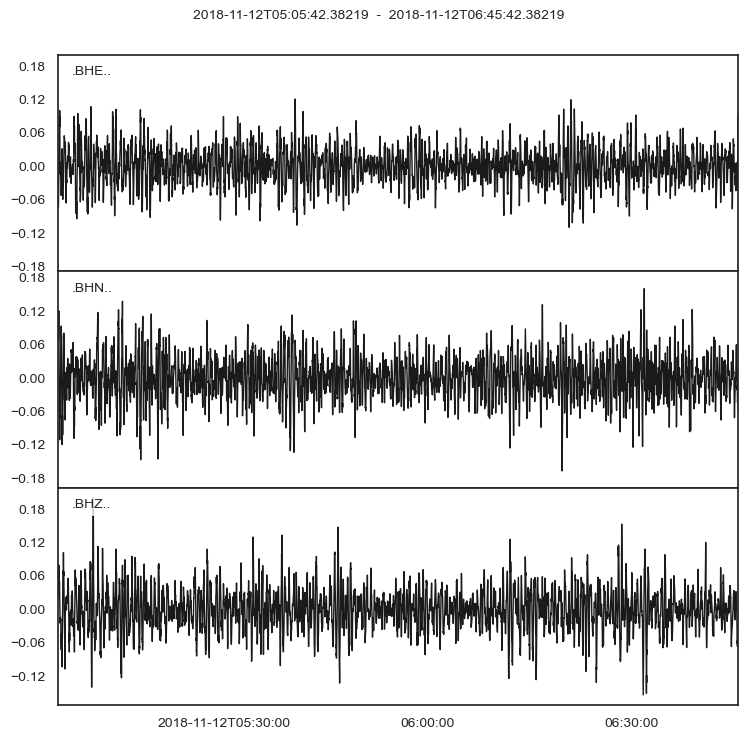

In [106]:
data = one_X_sc
trace_BHE = Trace(
    data=data[0],
    header={
        'starttime': start_time,'station' : "BHZ"})
trace_BHN = Trace(
    data=data[1],
    header={'starttime': start_time,'station' : "BHN"}
)
trace_BHZ = Trace(
    data=data[2],
    header={'starttime': start_time,'station' : "BHE"})

# Assemple into a Stream
stream = Stream([trace_BHE, trace_BHN, trace_BHZ])
stream_copy = stream.copy()
# Plot it
stream.plot()


In [91]:
print(np.array([i for i in stream[0]]))

[-0.01568435 -0.0145262  -0.01532155 ..., -0.03333156  0.00834778
  0.05298266]


In [92]:
print(nyquist_freq)

200.03333333333333


In [93]:
def bandpass_freqs(freqmin, freqmax, df):

    fe = 0.5 * df
    low = freqmin / fe
    high = freqmax / fe
    return low, high

low, high = bandpass_freqs(3, 5, 100)
print(low, high)

0.06 0.1


In [103]:
# Remove 'trend', e.g. remove linear offset from 0:
streamer = stream.copy()
#stream.detrend('demean')

# Taper the traces, meaning the ends will go gradually to 0 -- this is required before filtering
streamer.taper(max_percentage=0.05, type='cosine')

# Apply a bandpass filter, selecting frequencies from 3 to 5 Hz
#stream.bandpass(stream)
#stream.filter('bandpass', freqmin = 0.06, freqmax = 0.1)
streamer.filter('highpass', freq = 5)

# Now we can plot it again, and see that the signal is more pronounced
streamer.plot()

ValueError: Selected corner frequency is above Nyquist.